## UPLOADING LIBRARIES, PACKAGES AND DATAFILE

* GENERAL

In [117]:
import pandas as pd
import numpy as np

* PLOTS

In [118]:
import matplotlib.pyplot as plt   
import seaborn as sns

* REGRESSION

In [119]:
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor

* READING DATAFILE

In [120]:
df = pd.read_excel('odot.xlsx')

## DATA PREPROCESSING

In [121]:
df.Ratio=df.Price/df.FairPr

In [122]:
df.describe()

,Price,FairPr,Ratio,Bidders,Rigged,Length,FxCost,Days
count,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000
mean,985.541353,1059.533835,0.950344,5.150376,0.270677,4.542857,516.429639,185.150376
std,1494.291210,1628.365678,0.143738,2.880173,0.445989,4.627966,1012.171017,173.985087
min,23.000000,22.000000,0.564278,1.000000,0.000000,0.100000,1.200000,30.000000
25%,167.000000,174.000000,0.846491,3.000000,0.000000,1.400000,26.268000,75.000000
50%,431.000000,435.000000,0.945107,4.000000,0.000000,3.100000,89.880000,125.000000
75%,924.000000,970.000000,1.045455,7.000000,1.000000,6.200000,378.219000,210.000000
max,9453.000000,9480.000000,1.304598,13.000000,1.000000,23.500000,6086.160000,900.000000


* CORRELATION

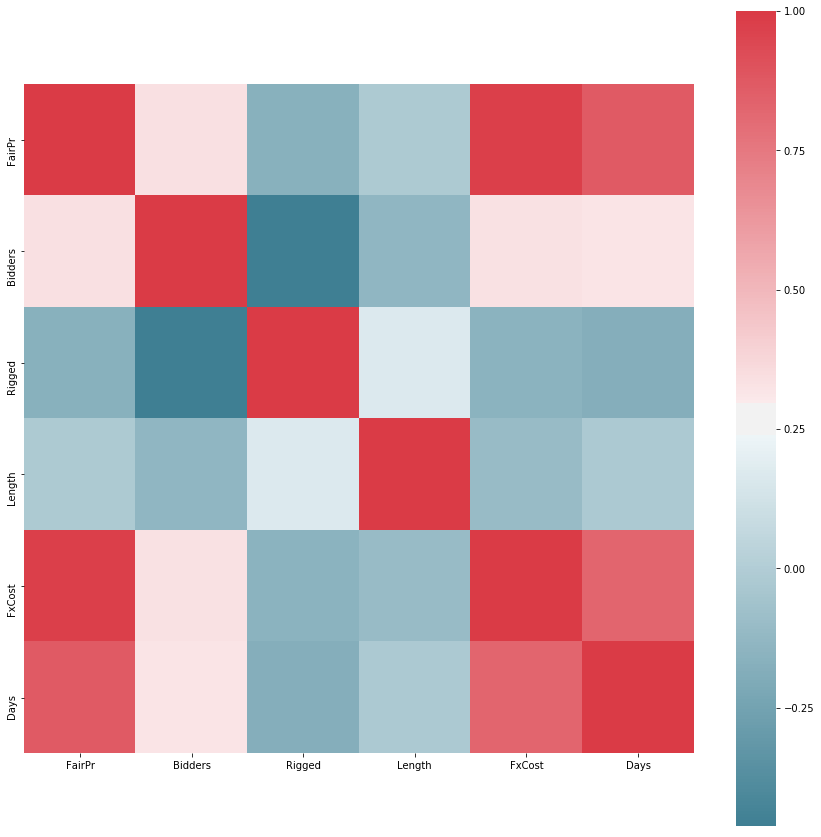

In [123]:
#correlation matrix
X = df[['FairPr', 'Bidders', 'Rigged', 'Length', 'FxCost', 'Days']]
f, ax = plt.subplots(figsize=(15, 15))
corr = X.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

## MODEL 1

* FITTING A REGRESSION MODEL

In [124]:
results = smf.ols('Ratio ~ FairPr + Bidders + Rigged + Length + FxCost + Days', data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Ratio   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     15.48
Date:                Mon, 14 Jan 2019   Prob (F-statistic):           3.04e-13
Time:                        16:04:06   Log-Likelihood:                 106.50
No. Observations:                 133   AIC:                            -199.0
Df Residuals:                     126   BIC:                            -178.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9192      0.029     31.638      0.0

In [125]:
results.conf_int(alpha=0.1)

,0,1
Intercept,0.871067,0.967355
FairPr,-0.000121,0.000025
Bidders,-0.014133,-0.000876
Rigged,0.141865,0.224587
Length,-0.003195,0.005088
FxCost,-0.000049,0.000159
Days,0.000006,0.000410


* MULTICOLLINEARITY

In [126]:
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
lzip(X.columns, vif)

[('FairPr', 77.30138244893712),
 ('Bidders', 2.586880559860412),
 ('Rigged', 1.3403498715266824),
 ('Length', 2.5203119782872654),
 ('FxCost', 53.90230996264113),
 ('Days', 9.11122708185233)]

* FUNCTIONAL FORM OF A MODEL

In [127]:
# source: https://www.statsmodels.org/dev/_modules/statsmodels/stats/outliers_influence.html
def reset_ramsey(res, degree=5):
    '''Ramsey's RESET specification test for linear models

    This is a general specification test, for additional non-linear effects
    in a model.


    Notes
    -----
    The test fits an auxiliary OLS regression where the design matrix, exog,
    is augmented by powers 2 to degree of the fitted values. Then it performs
    an F-test whether these additional terms are significant.

    If the p-value of the f-test is below a threshold, e.g. 0.1, then this
    indicates that there might be additional non-linear effects in the model
    and that the linear model is mis-specified.


    References
    ----------
    http://en.wikipedia.org/wiki/Ramsey_RESET_test

    '''
    order = degree + 1
    k_vars = res.model.exog.shape[1]
    #vander without constant and x:
    y_fitted_vander = np.vander(res.fittedvalues, order)[:, :-2] #drop constant
    exog = np.column_stack((res.model.exog, y_fitted_vander))
    res_aux = OLS(res.model.endog, exog).fit()
    #r_matrix = np.eye(degree, exog.shape[1], k_vars)
    r_matrix = np.eye(degree-1, exog.shape[1], k_vars)
    #df1 = degree - 1
    #df2 = exog.shape[0] - degree - res.df_model  (without constant)
    return res_aux.f_test(r_matrix) #, r_matrix, res_aux

In [128]:
name = ['t value', 'p value']
test = reset_ramsey(results)
test

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[0.47498008]]), p=0.7540258334875081, df_denom=122, df_num=4>

Ramsey RESET Test
<br> H_0: correct specification of the model
<br> H_1: the model suffers from misspecification
<br> RESET = 0.754 > 0.05 => no reason to reject null hyphothesis
<br> The functional form of a model is correctly specified.

* NORMALITY OF THE RESIDUALS

Jarque-Bera Test
<br> H_0: residuals have a normal distribution
<br> H_1: residuals do not have a normal distribution
<br> JB = 0.817 > 0.05 => no reason to reject null hyphothesis
<br> Residuals have a normal distribution.

* HETEROSKEDASTICITY

In [129]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(results.resid, results.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 4.284121414130722),
 ('p-value', 0.6382871372608576),
 ('f-value', 0.6989545554531295),
 ('f p-value', 0.6509261255146672)]

Breush-Pagan test
<br> H_0: homoskedasticity
<br> H_1: heteroskedasticity
BP = 0.638 > 0.05 => no reason to reject null hyphothesis
<br> The problem of heteroskedasticity does not occure in this model. 


#### (i) Give your best estimate and a 90% confidence interval of what will happen to the ratio of the actual price to the estimated cost if the number of days for a project decreases by 250, holding the other independent variables fixed.

In [120]:
days_change = - 250

mean = results.params.loc['Days'] * days_change
interval = results.conf_int(alpha=0.1).loc['Days'] * days_change

pred = lzip(['Mean', '10% Lower Bound', '10% Upper Bound'], [mean, interval[0], interval[1]])
pred
a= results.get_prediction()
a.summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,0.879318,0.019444,0.840839,0.917796,0.655092,1.103543
1,0.872160,0.019413,0.833742,0.910578,0.647945,1.096375
2,1.088919,0.022794,1.043810,1.134029,0.863462,1.314377
3,1.100298,0.022764,1.055248,1.145348,0.874852,1.325744
4,0.913104,0.018568,0.876357,0.949850,0.689169,1.137038
5,0.913041,0.021799,0.869901,0.956182,0.687969,1.138113
6,1.081932,0.023101,1.036216,1.127648,0.856352,1.307512
7,0.922460,0.019325,0.884216,0.960704,0.698275,1.146645
8,0.910005,0.018754,0.872893,0.947118,0.686010,1.134000
9,0.878486,0.017282,0.844287,0.912686,0.654956,1.102017


#### (ii) Can you claim at the usual 5% significance level that an increase in the number of bidders, holding the other independent variables fixed, will on average decrease the ratio of the price of a project relative to the ODOT estimate?

Analyzing table "OLS Regression Results" and values of P>|t| for each coefficient, assuming 5% level of significance, we are not in a position to claim that increasing the number of bidders will decrease the ratio. (p-value of Bidders: 0.063 > 0.05)

#### (iii) Would it be legitimate, at the usual 5% significance level, to drop the variables FairPr and FxCost out of the regression, if you wanted to do so? If the answer is yes, write down the new estimated regression equation.

Analyzing table "OLS Regression Results" and values of P>|t| for each coefficient, assuming 5% level of significance, we are in a position to claim that variables FairPr and FxCost are not statistically significant so we can drop the out of the regression. 

In [44]:
results1 = smf.ols('Ratio ~ Bidders + Rigged + Length + Days', data=df).fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Ratio   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     22.91
Date:                Mon, 14 Jan 2019   Prob (F-statistic):           2.73e-14
Time:                        14:46:29   Log-Likelihood:                 105.68
No. Observations:                 133   AIC:                            -201.4
Df Residuals:                     128   BIC:                            -186.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9273      0.028     33.396      0.0

(iv) One of your colleagues, Stan, draws your attention to a potential problem in the regression. He claims, “Almost all of the jobs the attorney general classified as rigged took place during the hot summer months. Everyone knows that jobs in the hot weather are harder to do, and therefore command a greater premium over estimated costs than jobs done at other times of the year.”

#### (a) If Stan is right then what is wrong with the regression?

#### (b) Suppose you can gather data regarding the time of year each job took place and use it to create a new variable, HOT (= 1 if the job took place during the hot summer months and = 0 otherwise). If Stan is right, what will change (and how) when you include HOT as an additional independent variable in the regression?

## MODEL 2

Develop a sound regression model to estimate and predict the winning bid (Price) on the final contract for 2018, which has the characteristics below.
<br> • The estimated cost is 10,000,000, of which 7,000,000 is due to fixed costs.
<br> • The 4 contractors interested in the project are expected not to rig the auction.

* FITTING A REGRESSION MODEL

In [46]:
results2 = smf.ols('Price ~ FairPr + Bidders + Rigged + FxCost', data=df).fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     973.5
Date:                Mon, 14 Jan 2019   Prob (F-statistic):           9.44e-95
Time:                        15:07:41   Log-Likelihood:                -931.11
No. Observations:                 133   AIC:                             1872.
Df Residuals:                     128   BIC:                             1887.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     93.9664     64.099      1.466      0.1

In [47]:
results3 = smf.ols('Price ~ FairPr + Bidders + Rigged', data=df).fit()
print(results3.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     1301.
Date:                Mon, 14 Jan 2019   Prob (F-statistic):           3.47e-96
Time:                        15:08:07   Log-Likelihood:                -931.49
No. Observations:                 133   AIC:                             1871.
Df Residuals:                     129   BIC:                             1883.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     78.4696     61.421      1.278      0.2

In [49]:
results3.conf_int(alpha=0.1)

,0,1
Intercept,-23.289104,180.228365
FairPr,0.890713,0.941646
Bidders,-33.137839,-1.114195
Rigged,-7.905811,189.334474


* MULTICOLLINEARITY

In [50]:
X_1 = df[['FairPr', 'Bidders', 'Rigged']]

In [51]:
vif = [variance_inflation_factor(X_1.values, i) for i in range(X_1.shape[1])]
lzip(X_1.columns, vif)

[('FairPr', 1.6123719489065504),
 ('Bidders', 1.6841488442073644),
 ('Rigged', 1.0739000919206745)]

* FUNCTIONAL FORM OF A MODEL

In [52]:
name = ['t value', 'p value']
test = reset_ramsey(results3)
test

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[1286.27748349]]), p=7.24548266486042e-103, df_denom=129, df_num=4>

Ramsey RESET Test
<br> H_0: correct specification of the model
<br> H_1: the model suffers from misspecification
<br> RESET = 7.24548266486042e-103 < 0.05 => there is a reason to reject null hyphothesis
<br> The model suffers from misspecification.

* NORMALITY OF THE RESIDUALS

Jarque-Bera Test
<br> H_0: residuals have a normal distribution
<br> H_1: residuals do not have a normal distribution
<br> JB = 0.00 > 0.05 => there is a reason to reject null hyphothesis
<br> Residuals do not have a normal distribution

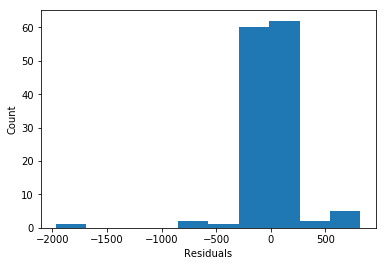

In [112]:
plt.hist(results3.resid)
plt.ylabel('Count')
plt.xlabel('Residuals')
plt.show()

* HETEROSKEDASTICITY

In [74]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(results3.resid, results3.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 47.30678503749735),
 ('p-value', 2.990676834816012e-10),
 ('f-value', 23.73807258255512),
 ('f p-value', 2.677834124908958e-12)]

Breush-Pagan test
<br> H_0: homoskedasticity
<br> H_1: heteroskedasticity
BP = 2.990676834816012e-10 < 0.05 => there is a reason to reject null hyphothesis
<br> The problem of heteroskedasticity occures in this model. 

## MODEL 3

SOME COMMMENT WHY

* FITTING A REGRESSION MODEL

In [76]:
df['logPrice']=np.log(df['Price'])
df['logFxCost']=np.log(df['FxCost'])
results4 = smf.ols('logPrice ~ FairPr + Bidders + Rigged + logFxCost', data=df).fit()
print(results4.summary())

                            OLS Regression Results                            
Dep. Variable:               logPrice   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     179.5
Date:                Mon, 14 Jan 2019   Prob (F-statistic):           1.78e-51
Time:                        15:50:47   Log-Likelihood:                -102.96
No. Observations:                 133   AIC:                             215.9
Df Residuals:                     128   BIC:                             230.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.4241      0.166     20.672      0.0

In [83]:
results4 = smf.ols('logPrice ~ FairPr + Rigged + logFxCost', data=df).fit()
print(results4.summary())

                            OLS Regression Results                            
Dep. Variable:               logPrice   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     238.2
Date:                Mon, 14 Jan 2019   Prob (F-statistic):           2.09e-52
Time:                        15:52:50   Log-Likelihood:                -103.67
No. Observations:                 133   AIC:                             215.3
Df Residuals:                     129   BIC:                             226.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3489      0.153     21.898      0.0

In [117]:
results4.coef

AttributeError: 'OLSResults' object has no attribute 'coef'

In [84]:
df.head()

,Price,FairPr,Ratio,Bidders,Rigged,Length,FxCost,Days,logPrice,logFxCost
0,1115,1149,0.970409,9,0,0.1,561.861,250,7.016610,6.331254
1,46,62,0.741935,8,0,0.1,62.000,60,3.828641,4.127134
2,240,195,1.230769,3,1,0.2,85.215,65,5.480639,4.445177
3,64,57,1.122807,2,1,0.2,16.074,70,4.158883,2.777203
4,170,187,0.909091,3,0,0.2,80.784,100,5.135798,4.391779


In [85]:
results4.conf_int(alpha=0.1)

,0,1
Intercept,3.095513,3.602250
FairPr,0.000135,0.000283
Rigged,0.047376,0.399991
logFxCost,0.448709,0.573853


* MULTICOLLINEARITY

In [114]:
X_2 = df[['FairPr', 'Rigged', 'logFxCost']]

In [115]:
vif = [variance_inflation_factor(X_2.values, i) for i in range(X_2.shape[1])]
lzip(X_2.columns, vif)

[('FairPr', 2.4736953694751724),
 ('Rigged', 1.391865859097974),
 ('logFxCost', 3.0491460773198384)]

* FUNCTIONAL FORM OF A MODEL

In [81]:
name = ['t value', 'p value']
test = reset_ramsey(results4)
test

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[24.02984396]]), p=9.899838124925551e-15, df_denom=124, df_num=4>

Ramsey RESET Test
<br> H_0: correct specification of the model
<br> H_1: the model suffers from misspecification
<br> RESET = 9.899838124925551e-15 < 0.05 => there is a reason to reject null hyphothesis
<br> The model suffers from misspecification.

* NORMALITY OF THE RESIDUALS

Jarque-Bera Test
<br> H_0: residuals have a normal distribution
<br> H_1: residuals do not have a normal distribution
<br> JB = 0.0324 < 0.05 => there is a reason to reject null hyphothesis
<br> Residuals do not have a normal distribution

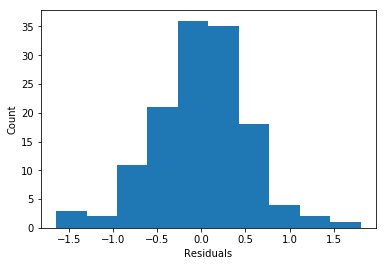

In [111]:
plt.hist(results4.resid)
plt.ylabel('Count')
plt.xlabel('Residuals')
plt.show()

<br> Assumption of Normal Distribution of Residuals does not have to be met. According to Gauss-Markov Theorem Least Squares Regression is the BLUE estimator regardless of it. A normal distribution is only used to show that the estimator is also the Maximum Likelihood Estimator. 

* HETEROSKEDASTICITY

In [82]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(results4.resid, results4.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 34.38240491012998),
 ('p-value', 6.220381824979775e-07),
 ('f-value', 11.156598942830794),
 ('f p-value', 8.52566706416611e-08)]

Breush-Pagan test
<br> H_0: homoskedasticity
<br> H_1: heteroskedasticity
BP = 6.220381824979775e-07 < 0.05 => there is a reason to reject null hyphothesis
<br> The problem of heteroskedasticity occures in this model. 

#### MODEL 4

Due to the heteroskedasticity of residuals the model was re-estimated using the Weighted Least Squares Method that is a special case of the Generalized Least Squares Method.

variance of residuals

In [ ]:
1/sqrt(exp(auxilary.lm$fitted.values))

In [ ]:
w = 1/sqrt(exp(auxilary.lm$fitted.values))

In [106]:
nsample = 133
w = np.ones(nsample)
y = df['logPrice']
x = df[['FairPr', 'Rigged', 'logFxCost']]
mod_wls = smf.WLS(y, x, data=df, weights=1./w)
res_wls = mod_wls.fit()
print(res_wls.summary())

                            WLS Regression Results                            
Dep. Variable:               logPrice   R-squared:                       0.966
Model:                            WLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     1215.
Date:                Mon, 14 Jan 2019   Prob (F-statistic):           7.14e-95
Time:                        16:45:30   Log-Likelihood:                -206.82
No. Observations:                 133   AIC:                             419.6
Df Residuals:                     130   BIC:                             428.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
FairPr        -0.0003   8.16e-05     -3.884      0.0

#### (a) Write down the estimated regression equation and explain how you came to choose it.

#### (b) Give a point estimate for the winning bid and provide an interval that will contain the winning bid with 90% confidence.

#### (c) How confident are you that in this project the winning bid will come in “under budget” (so that Bob will earn his bonus)?

## MODEL 4

ODOT has a road reconstruction project that is in the early planning phase. Just before putting the job up for auction, it is learnt that building an additional pedestrian bridge will be necessary as part of the project. This change will not affect the duration of the job or the length of the road, but it will increase fixed costs (FxCost) by 15% and overall estimated costs (FairPr) by 5%.
<BR> ODOT hasn’t put the project up for bidding yet, and your goal is to estimate the percentage increase in the winning bid (the Price of the contract) that will ultimately result from the change in projected costs.

#### (a) What regression would you use to estimate the increase in Price? Write down the estimated regression equation, and explain how you arrived at that regression.


#### (b) Using your regression in part (a), what is your estimate for the percentage increase in the Price of this contract?